# Estimation Walkthrough

In [37]:
from shapely.geometry import Polygon
import numpy as np
%matplotlib inline

In [38]:
import geopandas as gpd
from tobler import area_weighted

In [39]:
from tobler.area_weighted import _area_tables_binning as area_tables
from tobler.area_weighted import area_interpolate

## Example: Two GeoDataFrames

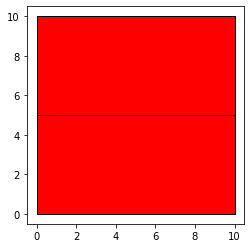

In [40]:
polys1 = gpd.GeoSeries([Polygon([(0,0), (10,0), (10,5), (0,5)]),
                      Polygon([(0,5), (0,10),  (10,10), (10,5)])])

polys2 = gpd.GeoSeries([Polygon([(0,0), (5,0), (5,7), (0,7)]),
                      Polygon([(5,0), (5,10),  (10,10), (10,0)]),
                       Polygon([(0,7), (0,10), (5,10), (5,7)  ])
                       ])

df1 = gpd.GeoDataFrame({'geometry': polys1})
df2 = gpd.GeoDataFrame({'geometry': polys2})
df1['population'] = [ 500,  200]
df1['pci'] = [75, 100]
df1['income'] = df1['population'] * df1['pci']

df2['population'] = [ 500,  100, 200]
df2['pci'] = [75, 80, 100]
df2['income'] = df2['population'] * df2['pci']

ax = df1.plot(color='red', edgecolor='k')

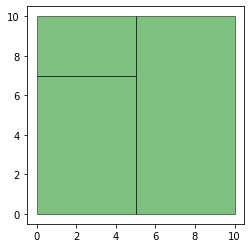

In [41]:
ax = df2.plot(color='green', alpha=0.5, edgecolor='k')

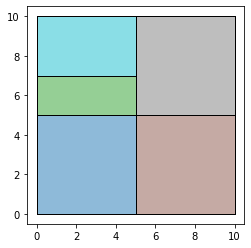

In [42]:
res_union = gpd.overlay(df1, df2, how='union')
ax = res_union.plot(alpha=0.5, cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k');
df2.plot(ax=ax, facecolor='none', edgecolor='k');

## Area Table

In [43]:
area_tables?

Signature: area_tables(source_df, target_df, spatial_index)
Docstring:
Construct area allocation and source-target correspondence tables using a spatial indexing approach
...

NOTE: this currently relies on Geopandas' spatial index machinery

Parameters
----------
source_df : geopandas.GeoDataFrame
    GeoDataFrame containing input data and polygons
target_df : geopandas.GeoDataFramee
    GeoDataFrame defining the output geometries
spatial_index : str
    Spatial index to use to build the allocation of area from source to
    target tables. It currently support the following values:
        - "source": build the spatial index on `source_df`
        - "target": build the spatial index on `target_df`
        - "auto": attempts to guess the most efficient alternative.
          Currently, this option uses the largest table to build the
          index, and performs a `bulk_query` on the shorter table.

Returns
-------
tables : scipy.sparse.dok_matrix
File:      ~/projects/tobler/tobler/ar

In [44]:
area_tables(df1, df2, 'auto')

<2x3 sparse matrix of type '<class 'numpy.float32'>'
	with 5 stored elements in Dictionary Of Keys format>

In [45]:
area_tables(df2, df1, 'auto')

<3x2 sparse matrix of type '<class 'numpy.float32'>'
	with 5 stored elements in Dictionary Of Keys format>

In [46]:
extensive_vars = ['population', 'income']
intensive_vars = ['pci']
estimates = area_interpolate(df1, df2, extensive_variables = extensive_vars,
                            intensive_variables = intensive_vars)

estimates

,population,income,pci,geometry
0,289.999998,22749.999762,82.14286,"POLYGON ((0.00000 0.00000, 5.00000 0.00000, 5...."
1,350.000000,28750.000000,87.50000,"POLYGON ((5.00000 0.00000, 5.00000 10.00000, 1..."
2,59.999996,5999.999642,100.00000,"POLYGON ((0.00000 7.00000, 0.00000 10.00000, 5..."


In [47]:
extensive_vars = ['population', 'income']
intensive_vars = ['pci']
estimates = area_interpolate(df2, df1, extensive_variables = extensive_vars,
                            intensive_variables = intensive_vars)
estimates

,population,income,pci,geometry
0,407.142866,30785.714924,77.500000,"POLYGON ((0.00000 0.00000, 10.00000 0.00000, 1..."
1,392.857149,34714.286193,84.999997,"POLYGON ((0.00000 5.00000, 0.00000 10.00000, 1..."


## Non-exhuastive case

Here the first set of polygons have an envelope that does not coincide with that of the second dataframe.


<AxesSubplot:>

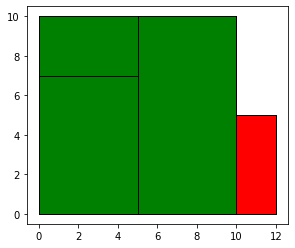

In [48]:
polys1 = gpd.GeoSeries([Polygon([(0,0), (12,0), (12,5), (0,5)]),
                      Polygon([(0,5), (0,10),  (10,10), (10,5)])])

polys2 = gpd.GeoSeries([Polygon([(0,0), (5,0), (5,7), (0,7)]),
                      Polygon([(5,0), (5,10),  (10,10), (10,0)]),
                       Polygon([(0,7), (0,10), (5,10), (5,7)  ])
                       ])

df1 = gpd.GeoDataFrame({'geometry': polys1})
df2 = gpd.GeoDataFrame({'geometry': polys2})
df1['population'] = [ 500,  200]
df1['pci'] = [75, 100]
df1['income'] = df1['population'] * df1['pci']

df2['population'] = [ 500,  100, 200]
df2['pci'] = [75, 80, 100]
df2['income'] = df2['population'] * df2['pci']

ax = df1.plot(color='red', edgecolor='k')
df2.plot(ax=ax, color='green',edgecolor='k')


In [49]:
extensive_vars = ['population']
intensive_vars = ['pci']
estimates = area_interpolate(df1, df2, extensive_variables = extensive_vars,
                            intensive_variables = intensive_vars)
estimates

,population,pci,geometry
0,289.999998,82.14286,"POLYGON ((0.00000 0.00000, 5.00000 0.00000, 5...."
1,350.000000,87.50000,"POLYGON ((5.00000 0.00000, 5.00000 10.00000, 1..."
2,59.999996,100.00000,"POLYGON ((0.00000 7.00000, 0.00000 10.00000, 5..."


In [50]:
estimates.sum()

population    699.999994
pci           269.642860
dtype: float64

In [51]:
extensive_vars = ['population']
intensive_vars = ['pci']
estimates = area_interpolate(df1, df2, extensive_variables = extensive_vars,
                            intensive_variables = intensive_vars,
                            allocate_total=False)
estimates

,population,pci,geometry
0,248.333333,82.14286,"POLYGON ((0.00000 0.00000, 5.00000 0.00000, 5...."
1,308.333333,87.50000,"POLYGON ((5.00000 0.00000, 5.00000 10.00000, 1..."
2,60.000000,100.00000,"POLYGON ((0.00000 7.00000, 0.00000 10.00000, 5..."


In [52]:
estimates.sum()

population    616.666667
pci           269.642860
dtype: float64

When setting `allocate_total=False` the total population of a source zone is not completely allocated, but rather the proportion of total population is set to the area of intersection over the area of the source zone.

This will have no effect when the source df is df2 and the target df is df 1:

In [53]:
extensive_vars = ['population']
estimates = area_interpolate(df2, df1, extensive_variables = extensive_vars)
estimates

,population,geometry
0,407.142866,"POLYGON ((0.00000 0.00000, 12.00000 0.00000, 1..."
1,392.857149,"POLYGON ((0.00000 5.00000, 0.00000 10.00000, 1..."


In [54]:
extensive_vars = ['population']
estimates = area_interpolate(df2, df1, extensive_variables = extensive_vars, allocate_total=False)
estimates

,population,geometry
0,407.142857,"POLYGON ((0.00000 0.00000, 12.00000 0.00000, 1..."
1,392.857143,"POLYGON ((0.00000 5.00000, 0.00000 10.00000, 1..."
